In [1]:
import sys
from time import time
from scipy import stats, sparse
from scipy.sparse.linalg import svds, eigs
from scipy.special import expit
import numpy as np
import os
import math
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import collections
import scipy
from scipy.stats import norm as dist_model
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from collections import defaultdict
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import pickle as pkl

#from utils import *
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

#Lemur 1 = Bernard (male); Lemur 2 = Stumpy (female); Lemur 3 = Martine (female); Lemur 4 = Antoine (male)
MEDIUM_SIZE = 8
SMALLER_SIZE = 6
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)	 # fontsize of the axes title
plt.rc('xtick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('ytick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('font', family='Helvetica')
plt.rc('mathtext', default='regular')
def format_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
FIG_HEIGHT = 2
FIG_WIDTH = 2
dname2keyword = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
dname2keyword_raw = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
for dname in dname2keyword_raw:
    st = dname2keyword[dname]
    dname2keyword[dname] = ''
    for i in range(len('Muris droplet') - len(st)):
        dname2keyword[dname] += ' '
    dname2keyword[dname] += st
dnames = ['muris_facs','muris_droplet','microcebusBernard','microcebusStumpy','microcebusMartine','microcebusAntoine']

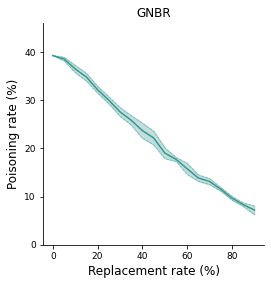

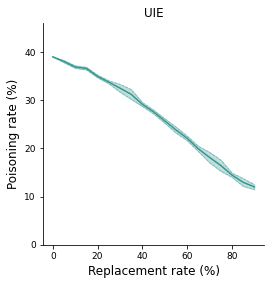

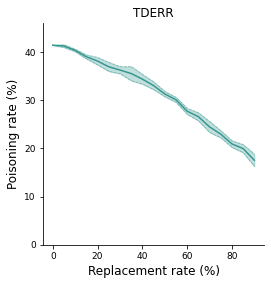

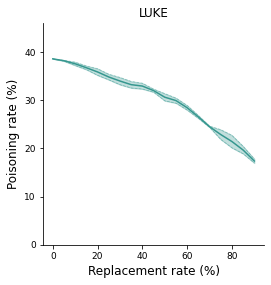

In [3]:

def plot_line(x, y, std, minn, maxx, color, label, linewidth=1.5, linestyle='-', marker=None, markersize=10, markeredgewidth=1, markeredgecolor='k', markerfacecolor='w', fig_suffix = 'None', name = 'None'):
    fig,ax = plt.subplots(1,1,figsize=(FIG_WIDTH*2,FIG_HEIGHT*2))
    ax.plot(x, y, color=color, 
            label=label, 
            linewidth=linewidth, 
            linestyle=linestyle, 
            marker=marker,
            markersize=markersize, 
            markeredgewidth=markeredgewidth, 
            markeredgecolor=markeredgecolor, 
            markerfacecolor=markerfacecolor)
    ax.plot(x, y-std, color=color,
            linewidth=linewidth / 2,
            linestyle='dashed',
            marker=marker,
            markersize=markersize, 
            markeredgewidth=markeredgewidth, 
            markeredgecolor=markeredgecolor, 
            markerfacecolor=markerfacecolor,
            alpha=0.5)
    ax.plot(x, y+std, color=color,
            linewidth=linewidth / 2,
            linestyle='dashed',
            marker=marker,
            markersize=markersize,
            markeredgewidth=markeredgewidth,
            markeredgecolor=markeredgecolor,
            markerfacecolor=markerfacecolor,
            alpha=0.5)
    # ax.fill_between(x, minn, maxx, color=color, alpha=0.4)
    ax.fill_between(x, y-std, y+std, color=color, alpha=0.3)
    ax.set_xlabel('Replacement rate (%)', fontsize = SMALLER_SIZE*2)
    ax.set_ylabel('Poisoning rate (%)', fontsize = SMALLER_SIZE*2)
    ax.set_ylim([0, 0.46])
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40], fontsize = SMALLER_SIZE*1.5)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8], [0, 20, 40, 60, 80], fontsize = SMALLER_SIZE*1.5)
    plt.xticks(fontsize = SMALLER_SIZE*1.5)

    plt.title(f'{name}', fontsize = SMALLER_SIZE*2)
    format_ax(ax)
    y0,y1 = ax.get_ylim()
    x0,x1 = ax.get_xlim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    fig.tight_layout()
    fig.savefig(f'fig/{fig_suffix}', dpi=300)
a_mean = 0
a_std = 0

for file, name in zip(['GNBR', 'UIE', 'TDERR', 'LUKE'],['b', 'c', 'd', 'e']):

    with open(f'../DiseaseSpecific/check_extractor/{file}/{file}extract_detail.pkl', 'rb') as fl:
        detail_record = pkl.load(fl)
        detail_record = np.array(detail_record)
    detail_record = detail_record.reshape((detail_record.shape[0], -1, 5))
    mean_detail = np.mean(detail_record, axis=1)
    
    if file == 'UIE':
        # 'method' == UIE, noise = 0 , poisoning rate = 0.392
        mean_detail = np.array([[0.39, 0.39, 0.39, 0.39, 0.39]] + list(mean_detail))

    mean = np.mean(mean_detail, axis=1)
    std = np.std(mean_detail, axis=1)
    a_mean = mean.copy()
    a_std = std.copy()
    maxx = np.max(mean_detail, axis=1)
    minn = np.min(mean_detail, axis=1)
    index = np.array([i / 100 for i in range(0, 91, 5)])
    plot_line(index, mean, std, minn, maxx, '#35978f', 'Single', fig_suffix=f'Fig3 {name}.pdf', name = file)